# Requirements

- pandas
- numpy
- seaborn
- matplotlib
- tikzplotlib
- jupyterthemes

In this script we analyse the results of the crowd-study

# General imports and settings

In [1]:
#!pip3 install matplotlib
#!pip3 install pandas
#!pip3 install seaborn
#!pip3 install tikzplotlib
#!pip3 install xlrd
#!pip3 install openpyxl
#!pip3 install krippendorff

In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tikzplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import textwrap
import warnings
from tqdm import tqdm

In [3]:
# Ignore warnings
warnings.filterwarnings('ignore')

## Rows till test questions
rows = 425000

# Data Loading

In [4]:
## Load the data. This can take a while
dat = pd.read_excel(open('../../Dataset/Text-Data/CrowdGuru-Ratings.xlsx', 'rb')) 

kommentare = pd.read_csv("../../Dataset/Text-Data/RP-Mod-Crowd.csv")


# Analysis

In [5]:
## filter out test questions
dat = dat.head(rows)

## transform na to 0
dat = dat.fillna(0)
dat.head()

,ID,Worker_ID,Rejected,Sexismus,Rassismus,Drohnung,Beleidigung,Profane Sprache,Meta / Organisatorisch,Werbung,Bearbeitungszeit_Cluster
0,1911223,40,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003032
1,1911223,115,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003079
2,1911223,485,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003403
3,1911223,527,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004213
4,1911223,530,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005787


In [6]:
# Aggregate number of rejections for a comment from different crowd workers
rejection_aggregation = dat.head(rows).groupby('ID').agg({'Rejected':['sum']})

# Transform rejection aggregation from pandas dataframe to numpy array
rejection_aggregation_np = np.array(rejection_aggregation.iloc[:,0])

# Calculate number of rejected and not rejected comments for CrowdGuru
rejected = np.count_nonzero(rejection_aggregation_np)
non_rejected = len(rejection_aggregation_np) - rejected

# Extract the original comments from the rp dataset that were classified by CrowdGuru
intersection_rp_crowdguru = kommentare[kommentare.id.isin(np.unique(dat.head(rows).ID))]
#print(intersection_rp_crowdguru)

# Calculate number of comments rejected and accepted by mods in RP dataset
mod_rejected = np.sum(intersection_rp_crowdguru["Reject Newspaper"])

mod_accepted = len(np.array(intersection_rp_crowdguru["Reject Newspaper"])) -  mod_rejected



moderator_rejections = np.array(intersection_rp_crowdguru[intersection_rp_crowdguru["Reject Newspaper"]==1].Text)
moderator_acceptance = np.array(intersection_rp_crowdguru[intersection_rp_crowdguru["Reject Newspaper"]==0].Text)

intersection_rp_crowdguru["Kommentarlänge"] = [len(str(x)) for x in list(kommentare.Text.values)]


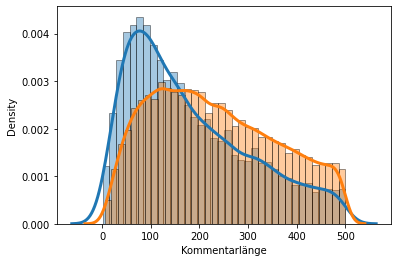

In [7]:
# Density Plot and Histogram of all arrival delays
sns.distplot(intersection_rp_crowdguru['Kommentarlänge'][intersection_rp_crowdguru['Reject Newspaper']==1], hist=True, kde=True, 
             bins=int(180/5), 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
textdist = sns.distplot(intersection_rp_crowdguru['Kommentarlänge'][intersection_rp_crowdguru['Reject Newspaper']==0], hist=True, kde=True, 
             bins=int(180/5), 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})

In [8]:
print("Comments " + str(len(intersection_rp_crowdguru['Kommentarlänge'])))
#print("Users "+ str(len(np.unique(intersection_rp_crowdguru["Loginname"]))))
#print("Articles "+str(len(np.unique(intersection_rp_crowdguru["CID"]))))

Comments 85000


In [9]:
# Count how often a comment was rejected
aggregation = dat.head(rows).groupby('ID').agg({'Rejected':['sum']})
aggregation.columns = ['Reject Newspaper']

index_no_rejection = aggregation.index.values[aggregation['Reject Newspaper'] == 0]

## now we get comments that are not rejected
no_rejected_comments = kommentare[kommentare.id.isin(index_no_rejection)]
no_rejected_comments = np.array(no_rejected_comments[no_rejected_comments['Reject Newspaper']==0].Text)
           
# Extract comments that were rejected by all 5 crowdworkers
ind_problematic = aggregation.index.values[(np.array(aggregation.iloc[:,0]==5))]
problematic_comments = kommentare[kommentare.id.isin(ind_problematic)]

In [10]:
# Calculate values for confusion matrix
#  Compares rp decision against crowdworker decisions
TP = 0
TN = 0
FP = 0
FN = 0
for id in tqdm(intersection_rp_crowdguru.id):
    moderator_abgelehnt = np.int(intersection_rp_crowdguru.loc[intersection_rp_crowdguru.id == id]['Reject Newspaper'])
    crowd_abgelehnt = np.int(aggregation.loc[aggregation.index.values == id]['Reject Newspaper'])
    if(moderator_abgelehnt > 0 and crowd_abgelehnt > 1):
        TP = TP + 1
    if(moderator_abgelehnt == 0 and crowd_abgelehnt < 2):
        TN = TN + 1
    if(moderator_abgelehnt > 0 and crowd_abgelehnt < 2):
        FN = FN + 1
    if(moderator_abgelehnt == 0 and crowd_abgelehnt > 1):
        FP = FP + 1

# Generate confusion matrix
confusion_matrix = np.array([[TP,FP],
                            [FN,TN]])

print(f"True positives: {TP}")
print(f"True negatives: {TN}")
print(f"False positives: {FP}")
print(f"False negatives: {FN}")



100%|███████████████████████████████████████████████████████████████████████████████| 85000/85000 [01:22<00:00, 1031.03it/s]

True positives: 2808
True negatives: 69474
False positives: 8385
False negatives: 4333


# Explorative analysis

In [11]:
# General numbers of the CrowdGuru and RP dataset
print(f"Shape of CrowdGuru dataset: {dat.shape}")
print(f"Shape of RP dataset: {kommentare.shape}")
print(f"Number of analysed comments in CrowdGuru dataset: {len(Counter(dat.head(rows).ID).values())}")
print(f"Number of reviews: {dat.head(rows).shape}")
print(f"Number of crowdworker: {len(np.unique(dat.head(rows).Worker_ID))}")
print(f"Number of crowdworker per comment:\n {dat.head(rows).groupby('ID').agg({'Worker_ID':[pd.Series.nunique]}).value_counts()}")

Shape of CrowdGuru dataset: (425000, 11)
Shape of RP dataset: (85000, 14)
Number of analysed comments in CrowdGuru dataset: 85000
Number of reviews: (425000, 11)
Number of crowdworker: 603
Number of crowdworker per comment:
 (Worker_ID, nunique)
5                       85000
dtype: int64


In [12]:
print(f"CrowdGuru Sperrungen: {rejected}")
print(f"CrowdGuru Annahmen: {non_rejected}")
print(f"Moderator Sperrungen: {mod_rejected}")
print(f"Moderator Annahmen: {mod_accepted}")

CrowdGuru Sperrungen: 28833
CrowdGuru Annahmen: 56167
Moderator Sperrungen: 7141
Moderator Annahmen: 77859


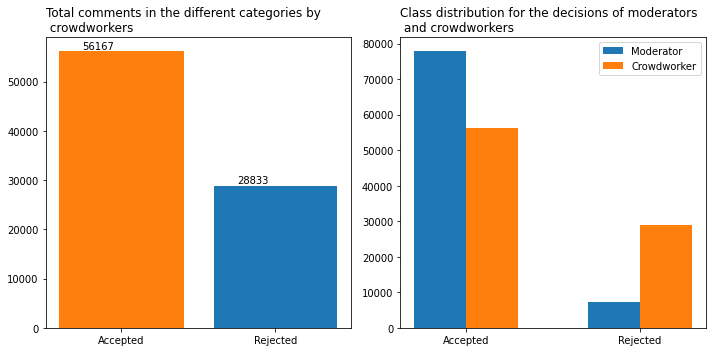

In [13]:
# Create subplots
x_global = np.arange(2)

# Create plot of comment distribution by crowdworkers dicisions
def create_distributin_plot(ax, title): 
    p = ax.bar([0,1],[non_rejected,rejected], align='center')
    p[0].set_color('tab:orange')
    for i, v in enumerate(np.array([non_rejected,rejected])):
        ax.text([0,1][i] - 0.25, v + 500, str(v))

    ax.set_xticks(x_global)
    ax.set_xticklabels(["Accepted","Rejected"])
    ax.set_title(title, loc= 'left')

# Create plot for comparison of decisions of rp moderators and crowdworkers
def create_comparison_plot(ax, title, moderator_decisions, crowdguru_decisions):
    width = 0.3
    ax.bar(x_global - width/2, moderator_decisions, width, label='Moderator')
    ax.bar(x_global + width/2, crowdguru_decisions, width, label='Crowdworker')
    ax.set_xticks(x_global)
    ax.set_xticklabels(["Accepted","Rejected"])
    ax.set_title(title, loc= 'left')
    ax.legend()

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(10,5))
create_distributin_plot(ax1, "Total comments in the different categories by\n crowdworkers")
create_comparison_plot(ax2, "Class distribution for the decisions of moderators\n and crowdworkers",
                      moderator_decisions = [mod_accepted,mod_rejected], crowdguru_decisions = [non_rejected,rejected])

fig.tight_layout()
plt.show()

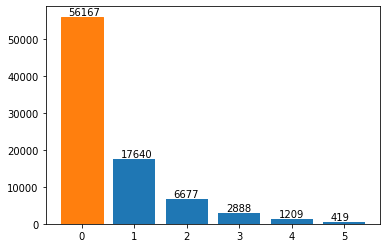

In [14]:
# Extract number of comments per number of rejections
count_number_rejections = Counter(aggregation.iloc[:,0])
z = list(zip(*count_number_rejections.items()))
labels,values=sorted(z, key=lambda x: x[0])

# Create plot to show number of comments per number of rejections
p2 = plt.bar(labels, values)
p2[0].set_color('tab:orange')
for i, v in count_number_rejections.items():
    plt.text(i - 0.25, v+500, str(v))
#plt.title(label="Verhältnis Kommentarablehnung nach Anzahl der Übereinstimmungen", loc= 'left')
#plt.show()

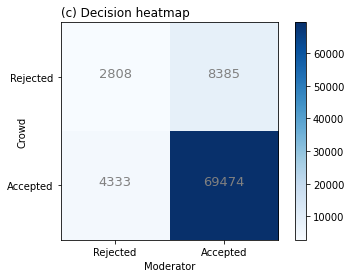

In [15]:
# Plot confusion matrix
def create_confusion_matrix(ax, title, labels, confusion_matrix):
    #fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap="Blues")

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title(title,loc="left")

    # Rotate the tick labels and set their alignment.
    ax.set_ylabel('Crowd')
    ax.set_xlabel('Moderator')

    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", color="grey",size=13)
        
    ax.figure.colorbar(im, ax=ax)
    ax.yaxis.labelpad = -20

fig, ax = plt.subplots()
create_confusion_matrix(ax, title="(c) Decision heatmap", labels=["Rejected","Accepted"], 
                        confusion_matrix=confusion_matrix)

plt.show()

In [16]:
def create_rejection_distribution_comparison(ax, title, width=0.4):
    ind = np.argsort(labels)

    moderators = []
    crowd = []
    ind = np.array(range(0,6))

    ind_problematic = aggregation.index.values[(np.array(aggregation.iloc[:,0]==0))]
    subset_data = kommentare[kommentare.id.isin(ind_problematic)]
    moderators.append(len(subset_data[subset_data['Reject Newspaper']==0]))
    crowd.append(len(ind_problematic))

    for i in range(1,6):   
        ind_problematic = aggregation.index.values[(np.array(aggregation.iloc[:,0]>=i))]
        subset_data = kommentare[kommentare.id.isin(ind_problematic)] 
        moderators.append(sum(subset_data['Reject Newspaper']))
        crowd.append(len(ind_problematic))
    
    ax.bar(ind - width/2, moderators, width, label="Moderator")
    for i, v in enumerate(moderators):
        ax.text(ind[i] - 0.2- width/2, v , str(v),size=8)

    ax.bar(ind + width/2, crowd, width, label="Crowdworker")
    for i, v in enumerate(crowd):
        ax.text(ind[i] - 0.2+ width/2, v , str(v), size=8)

    ax.set_xticks(ind)
    ax.legend()
    ax.set_title(title, loc="left")

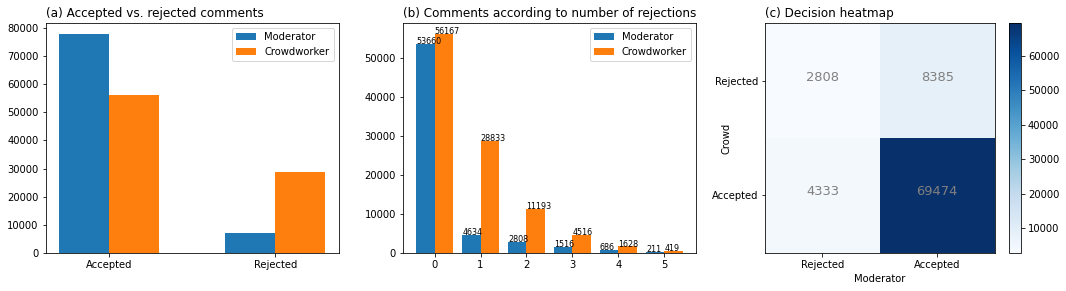

In [17]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

accept = [mod_accepted,mod_rejected]
reject = [non_rejected,rejected]
create_comparison_plot(ax1, "(a) Accepted vs. rejected comments", accept, reject)

create_rejection_distribution_comparison(ax2, title="(b) Comments according to number of rejections")

create_confusion_matrix(ax3, title="(c) Decision heatmap", labels=["Rejected","Accepted"], 
                        confusion_matrix=confusion_matrix)

plt.tight_layout()

#plt.savefig("../Figures/crowd_moderation.pdf", bbox_inches='tight')

## Inter-Annotator Analysis

In [18]:
comment_ids = []
num_rejected = []
## now load the rp-mod datasets and lets show how many rejects
for i in range(1,6):
    dataframe = pd.read_csv("../../Dataset/Text-Data/RP-Crowd-"+str(i)+".csv")
    comment_ids.append(list(dataframe["id"]))
    num_rejected.append(len(dataframe)/2)

In [19]:
## here we crate a dataset rows = moderators, columns = post id and cell content = binary decision
ids = np.unique(list(dat["ID"]))
workerids = np.unique(list(dat["Worker_ID"]))

m = np.empty((len(ids),len(workerids),))
m[:] = np.nan

df = pd.DataFrame(m)
df.columns = workerids
df.index = ids

for index, row in dat.iterrows():
    df.loc[row['ID'], row['Worker_ID']] = row['Rejected']

In [20]:
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import datetime
from sklearn.metrics import cohen_kappa_score
import krippendorff

## dataset needs to be transposed
dftransposed = df.T

## calculate krippendorffs alpha for all threshold agreements
alpha = []
for i in range(0,5):
    alpha.append(krippendorff.alpha(reliability_data=dftransposed[comment_ids[i]],level_of_measurement='nominal'))

In [21]:
def create_agreement(ax, title, width=0.4):
    color = 'C0'
    ax.set_xlabel('rejection threshold')
    ax.set_ylabel('rejected comments', color=color)
    #ax.plot(range(1, 6),num_rejected, 'd-', color=color)
    ax.step(range(1, 6),num_rejected, where='post', label='pre (default)', color = color)
    #ax.plot(range(1, 6),num_rejected, 'o--', color='grey', alpha=0.3)
    
    
    ax.tick_params(axis='y', labelcolor=color)
    ax.grid(axis='x', color='0.95')
    ax4 = ax3.twinx()
    color = 'C1'
    ax4.set_ylabel("krippendorff's alpha", color=color)  # we already handled the x-label with ax1
    #ax4.plot(range(1, 6),alpha, 'd-',color=color )
    ax4.step(range(1, 6),alpha, where='post', label='pre (default)', color = color)
    #ax4.plot(range(1, 6),alpha, 'o--', color='grey', alpha=0.3)
    ax4.tick_params(axis='y', labelcolor=color)
    ax4.set_xticks(range(1,6))
    ax.set_title(title, loc="left")
    
 

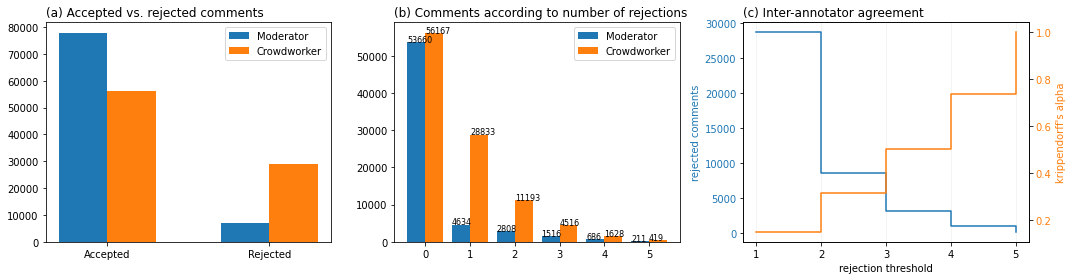

In [22]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

accept = [mod_accepted,mod_rejected]
reject = [non_rejected,rejected]
create_comparison_plot(ax1, "(a) Accepted vs. rejected comments", accept, reject)

create_rejection_distribution_comparison(ax2, title="(b) Comments according to number of rejections")

create_agreement(ax3, title="(c) Inter-annotator agreement")

plt.tight_layout()

plt.savefig("../Figures/crowd_moderation.pdf", bbox_inches='tight')